In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Conv2D, MaxPool2D  # Import Conv2D
from tensorflow.keras import models, layers, datasets, utils
import matplotlib.pyplot as plt

In [14]:
IMG_ROOT_DIR = "C:/Faster_Code/ASSN_7_INT_SYSTEMS/QR_codes"
# Global params for loading the images
batch_size = 8
img_height = 76
img_width = 76

In [15]:
qr_train, qr_test = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="both",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


'''
print("Splitting training set into validation and training set...")
qr_train, qr_val = utils.split_dataset(
    qr_train, 
    left_size=0.8,
    shuffle = True,
    seed = 123)
'''
'''
qr_train = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
qr_val = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)
qr_test = utils.image_dataset_from_directory(
    IMG_ROOT_DIR,
    image_size=(img_height, img_width),
    batch_size=batch_size)
'''

Found 549346 files belonging to 2 classes.
Using 439477 files for training.
Using 109869 files for validation.


'\nqr_train = utils.image_dataset_from_directory(\n    IMG_ROOT_DIR,\n    validation_split=0.2,\n    subset="training",\n    seed=123,\n    image_size=(img_height, img_width),\n    batch_size=batch_size)\nqr_val = utils.image_dataset_from_directory(\n    IMG_ROOT_DIR,\n    validation_split=0.2,\n    subset="validation",\n    seed=123,\n    image_size=(img_height, img_width),\n    batch_size=batch_size)\nqr_test = utils.image_dataset_from_directory(\n    IMG_ROOT_DIR,\n    image_size=(img_height, img_width),\n    batch_size=batch_size)\n'

In [16]:
qr_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 76, 76, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

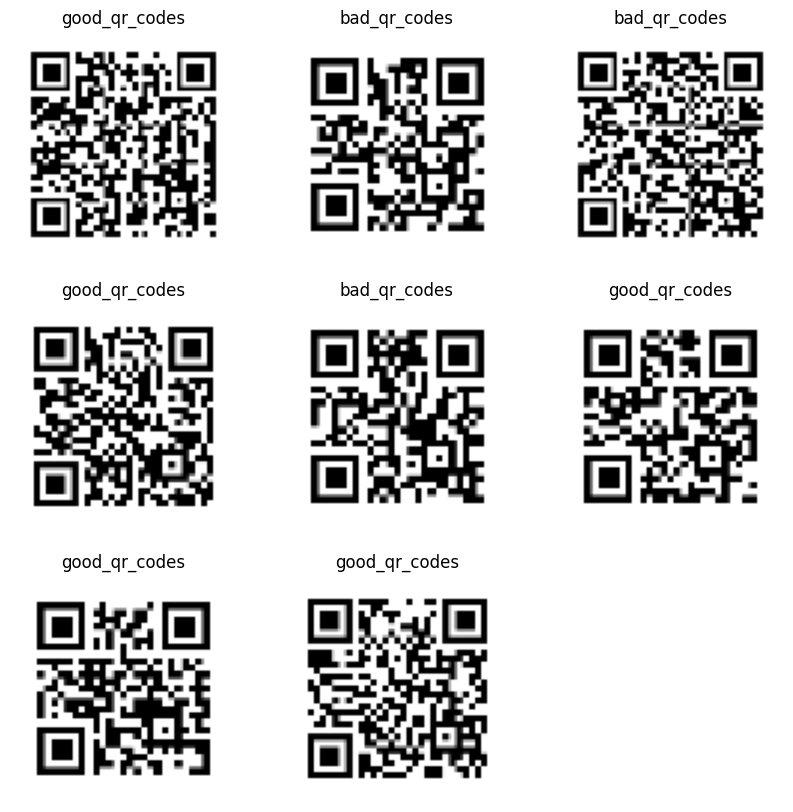

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in qr_train.take(1):
  for i in range(8):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(qr_train.class_names[labels[i]])
    plt.axis("off")

In [18]:
# Show image sizes and other info (batch_size, height, width, color_channels)
for image_batch, labels_batch in qr_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 76, 76, 3)
(8,)


In [19]:
# Normalization / Scaling of colors
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))
'''
# Do the same for the validation set
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_val.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Do the same for the testing set
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = qr_test.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
'''

0.0 1.0


'\n# Do the same for the validation set\nnormalization_layer = tf.keras.layers.Rescaling(1./255)\nnormalized_ds = qr_val.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\n\n# Do the same for the testing set\nnormalization_layer = tf.keras.layers.Rescaling(1./255)\nnormalized_ds = qr_test.map(lambda x, y: (normalization_layer(x), y))\nimage_batch, labels_batch = next(iter(normalized_ds))\n'

In [20]:
# Cache datasets for performance
AUTOTUNE = tf.data.AUTOTUNE

qr_train = qr_train.cache().prefetch(buffer_size=AUTOTUNE)
# qr_val = qr_val.cache().prefetch(buffer_size=AUTOTUNE)
qr_test = qr_test.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
# Create a model
num_classes = 2

model = tf.keras.Sequential([
  #tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(img_width, img_height, 3)),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

# Compile (Adam)
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 74, 74, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 35, 35, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 17, 17, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,482 (861.26 KB)

 Trainable params: 220,482 (861.26 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.fit(
  qr_train,
  #validation_split=0.2,
  epochs=3
)

Epoch 1/3
11164/54935 ━━━━━━━━━━━━━━━━━━━━ 11:35 16ms/step - accuracy: 0.7104 - loss: 0.8745

KeyboardInterrupt: 

In [ ]:
evaluation = model.evaluate(qr_test)
print("Accuracy of testing: {}".format(evaluation[1]))